# Calculate sigmav vs. mDM for simulated DM datasets

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u

from gammapy.astro.darkmatter.utils import SigmaVEstimator, DMDatasetOnOff
from gammapy.spectrum import CountsSpectrum
from gammapy.astro.darkmatter import DarkMatterAnnihilationSpectralModel
from gammapy.irf import load_cta_irfs

## Define parameters for simulated observation

In [2]:
# -
livetime = 100 * u.h # in hours
offset = 0.5 * u.deg
FOVLON=0 * u.deg
FOVLAT=0 * u.deg

# Energy from 0.01 to 100 TeV with 20 bins/decade
energy = np.logspace(-1.8, 1.5, 20) * u.TeV

# Energy true wider range and higher number of bins
energy_true = np.logspace(-2, 2, 100) * u.TeV

# DMAnnihilation Model
JFAC = 3.41e19 * u.Unit("GeV2 cm-5") # point source
mDM = 5000*u.Unit("GeV")
channel = "b"
redshift = 0

## Build IRFs with the defined parameters

In [3]:
# Load IRFs
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
cta_irf = load_cta_irfs(filename)

NDDataArray summary info
MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 42        
	node type  : edges     
	edges min  : 1.3e-02 TeV
	edges max  : 2.0e+02 TeV
	interp     : log       
MapAxis

	name       : offset    
	unit       : 'deg'     
	nbins      : 6         
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 6.0e+00 deg
	interp     : lin       
Data           : size =   252, min =  0.000 m2, max = 5371581.000 m2



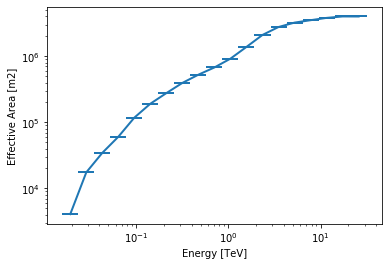

In [4]:
aeff = cta_irf["aeff"].to_effective_area_table(offset=offset, energy=energy)
aeff.plot()
plt.loglog()
print(cta_irf["aeff"].data)

In [5]:
#edisp = cta_irf["edisp"].to_energy_dispersion(
#    offset=offset, e_true=energy_true, e_reco=energy
#)
#edisp.plot_matrix()
#print(edisp.data)

## Build the background counts from PSF and IRF background

In [6]:
containment = 0.68
energies = np.sqrt(energy[1:] * energy[:-1])
psf = cta_irf["psf"].to_energy_dependent_table_psf(theta=offset)
on_radii = psf.containment_radius(energy=energies, fraction=containment)
solid_angles = 2 * np.pi * (1 - np.cos(on_radii)) * u.sr

#
aeff.data.data *= containment

In [7]:
bkg_data = cta_irf["bkg"].evaluate_integrate(
    fov_lon=FOVLON, fov_lat=FOVLAT, energy_reco=energy
)
bkg = CountsSpectrum(
    energy[:-1],
    energy[1:],
    data=(bkg_data * solid_angles).to_value("h-1")*livetime
)

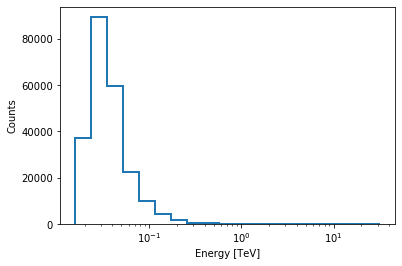

In [8]:
bkg.plot_hist()

## Simulate OnOff observation with DM emission model

In [9]:
# DM Flux
flux_model = DarkMatterAnnihilationSpectralModel(
    mass=mDM, 
    channel=channel, 
    jfactor=JFAC, 
    z=redshift
)

In [10]:
#from gammapy.modeling.models import Absorption, AbsorbedSpectralModel
#absorption_model = Absorption.read_builtin('dominguez')
#flux_model = AbsorbedSpectralModel(flux_model, absorption_model, redshift)

In [11]:
dataset = DMDatasetOnOff(
    aeff=aeff,
    model=flux_model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)

In [14]:
nuissance = dict(
    j=JFAC,
    jobs=JFAC,
    sigmaj=0.1*JFAC,
    sigmatau=0.01,
    #width=5,
    #steps=15,
)
dataset.nuissance = nuissance
dataset.check_nuissance() # True if valid values for nuissance are defined in the dataset.

True

**Enable inspection**

In [15]:
import logging
logging.basicConfig()
#logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("WARNING")
logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("DEBUG")

**The SigmaVEstimator class estimates $\sigma\nu$ for a list of annihilation channels and particle masses.**

In order to have statistics the overall process below is repeated for a given number of `runs`.

- For each run a **random poisson realization** of a `DMDatasetOnOff` is created as a simulated observation.
- For each run we consider a list of annihilation channels.
    - For each channel we consider a list of masses.
        - For each mass in each channel:
            - A specific `DarkMatterAnnihilationSpectralModel` is instantiated with parameters `JFactor`, `channel`, `mass`.
            - This specific annhilation flux model is attached to the `DMDatasetOnOff` dataset instance.
            - A fit of this specific annhilation model to the simulated observation of the run is performed for each of the `steps` values that the nuissance parameter `j` takes in a range of ± `sigmaj` * `width`. 
            - A fit is chosen: the one giving the minimum value for the likelihood.
            - A check (L<sub>0</sub> - L<sub>min</sub> ≤ 25) is done.
            - A value of the scale parameter `sv` giving ΔL=2.71 in the likelihood profile is chosen.
            - If the value of `sv` is not in the range of the physical region (>=0) or does not reach ΔL=2.71 we skip the run and take the next one.
            -  $\sigma\nu$  is the chosen value of `sv`is multiplied by the thermal relic cross section.

- Profile likelihoods and values calculated for `sv` and $\sigma\nu$ are provided for each run, channel and mass.
- For each channel a table of mean values across all runs of $\sigma\nu$ vs. mass is provided. 
- Messages are displayed according to the logging level sonfiguration defined.

**Instatiate estimator**

In [16]:
masses = [100, 200, 500, 1000, 5000, 10000, 50000]*u.GeV
channels = ["b", "tau", "Z"] 
estimator = SigmaVEstimator(dataset, masses, channels, background_model=bkg, jfactor=JFAC)

**Run estimator and fetch results**

In [17]:
%%time
#likelihood_profile_opts=dict(bounds=50, nvalues=50)
result = estimator.run(runs=10, nuissance=True)
#if nuissance = True the process takes the nuissance parameters into account.

INFO:gammapy.astro.darkmatter.utils:Run: 0
INFO:gammapy.astro.darkmatter.utils:Channel: b
INFO:gammapy.astro.darkmatter.utils:Mass: 100.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 119.232907870029
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 119.23287465113339
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 119.23286243121979
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 119.23285393775272
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 119.23284823545927
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 119.23284467280111
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 119.23284278042993
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 119.23284221159382
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 119.23284270461518
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 119.23284405841166


DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 119.90795129320433
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 119.9079517862257
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 119.90795314002217
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 119.90795519764656
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 119.90795783492733
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 119.90796095244926
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 119.90796446977843
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 119.90796832122936
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: -8.248373635287798
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 120.65091636633404
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 967.206861619018
DEBUG:gam

DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 119.47910035576525
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: -2.326631503649872
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 120.62511454360215
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 215.5701069589943
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 7583.1733 	| Max:  7706.508368283682
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 0.0000 	| Zero: 120.62511454360215
INFO:gammapy.astro.darkmatter.utils:Sigma v:5.896300091233845e-26
INFO:gammapy.astro.darkmatter.utils:Mass: 500.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 120.57995249311747
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 120.5798908943336
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 120.5798786772179
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood:

DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 118.2736144015087
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 118.27359696430136
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 118.27358474534705
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 118.27357625188
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 118.27357054958654
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 118.27356698692839
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 118.2735650945572
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 118.2735645257211
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 118.27356501874246
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 118.27356637253894
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 118.27356843016332
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likel

DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 119.65685865127013
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 119.6568600050666
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 119.65686206269099
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 119.65686469997176
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 119.65686781749369
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 119.65687133482287
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 119.6568751862738
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: -8.582177961110355
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 120.63014299582487
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 865.94413763789
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 6813.8105 	| Max:  6937.150684974292
DEBUG:gammap

DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: -15.655185293960193
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 105.98140073048629
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 2736.250675741497
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 8594.0086 	| Max:  8702.70005067055
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 0.0000 	| Zero: 105.98140073048629
INFO:gammapy.astro.darkmatter.utils:Sigma v:9.711478583828871e-25
INFO:gammapy.astro.darkmatter.utils:Mass: 200.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 105.91300007117525
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 105.91298273263668
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 105.91297051485863
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 105.91296202139156
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihoo

DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 105.87329488284587
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 105.87328266573017
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 105.87327417226311
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 105.87326846958636
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 105.8732649069282
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 105.87326301455703
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 105.87326244572091
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 105.87326293874227
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 105.87326429253875
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 105.87326635016314
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 105.87326898744391
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min 

DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 105.73973821938672
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 105.7397395731832
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 105.73974163080759
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 105.73974426808836
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 105.73974738561029
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 105.73975090293946
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 105.73975475439039
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 0.8435260781759135
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 105.73973772807058
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0.8435260781759135
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 174.57162657169323
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 5790.7492 	| Max:  5899.1989

DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 11.884372404492233
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 105.67209809800353
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 11.884372404492233
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 2264.109635076598
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 783.6382 	| Max:  892.0202756000299
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: -0.1856 	| Zero: 105.4865155441722
INFO:gammapy.astro.darkmatter.utils:Sigma v:1.6101514935725477e-24
INFO:gammapy.astro.darkmatter.utils:Channel: Z
INFO:gammapy.astro.darkmatter.utils:Mass: 100.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 105.26765997024431
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 105.26764154927011
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 105.26762933215441
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 105.26762083868735


DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 105.87421220045526
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 105.87419347795111
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 105.87418126083541
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 105.87417276736835
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 105.8741670650749
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 105.87416350241674
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 105.87416161004556
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 105.87416104120945
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 105.87416153423081
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 105.87416288802729
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 105.87416494565167
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min 

DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 138.9379293301459
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 138.93792982316728
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 138.93793117696373
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 138.93793323458812
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 138.9379358718689
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 138.93793898939083
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 138.93794250672
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 138.93794635817093
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: -4.464045803566172
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 139.01019570603364
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 1685.584054379053
DEBUG:gammap

DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 25.092740940788104
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 134.60970846583905
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 25.092740940788104
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 1247.5101623281873
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 3738.7685 	| Max:  3876.0881848425306
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 4.3991 	| Zero: 139.00885734453186
INFO:gammapy.astro.darkmatter.utils:Sigma v:1.3657794906398013e-24
INFO:gammapy.astro.darkmatter.utils:Mass: 50000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 137.73096859086013
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 137.7309512623122
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 137.7309390451965
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 137.73093055172944
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68

DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 134.01840517972482
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 134.01838408862088
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 134.01837187150517
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 134.01836337803812
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 134.01835767574465
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 134.0183541130865
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 134.01835222071531
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 134.01835165187921
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 134.01835214490058
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 134.01835349869705
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 134.01835555632144
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min 

DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 138.2644572369483
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 138.26445772996965
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 138.26445908376613
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 138.2644611413905
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 138.26446377867128
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 138.2644668961932
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 138.2644704135224
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 138.2644742649733
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: -34.65677740778006
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 139.0120999832154
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 3982.9252005992007
DEBUG:gammap

DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 21.16468767257418
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 134.33530455345797
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 21.16468767257418
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 1018.0051106191986
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 4188.6853 	| Max:  4325.730595135944
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 4.6789 	| Zero: 139.01417112964933
INFO:gammapy.astro.darkmatter.utils:Sigma v:1.1334062130415891e-24
INFO:gammapy.astro.darkmatter.utils:Mass: 10000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 136.10986877178996
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 136.10985141870663
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 136.10983920159094
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 136.10983070812387
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e

INFO:gammapy.astro.darkmatter.utils:Mass: 500.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 121.5594167220529
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 121.55934915806398
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 121.55933693968655
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 121.5593284462195
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 121.55932274392603
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 121.55931918126788
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 121.5593172888967
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 121.5593167200606
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 121.55931721308195
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 121.55931856687843
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 121.55932062450282
DEBUG:

DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 124.2044936557927
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 124.20449414881406
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 124.20449550261054
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 124.20449756023493
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 124.2045001975157
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 124.20450331503763
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 124.2045068323668
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 124.20451068381773
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: -1.0647273472724659
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 123.97914875208342
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 2430.13196889177
DEBUG:gamm

DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 121.98579080390111
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 2.657315389748112
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 121.98577377587608
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 2.657315389748112
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 182.862665270228
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 4385.1839 	| Max:  4509.87963239444
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 2.1858 	| Zero: 124.1716097580291
INFO:gammapy.astro.darkmatter.utils:Sigma v:1.6941950594274295e-25
INFO:gammapy.astro.darkmatter.utils:Mass: 5000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 124.16648577055294
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 124.16646757323645
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 124.16645535525222
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	

INFO:gammapy.astro.darkmatter.utils:Mass: 200.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 123.43488277035432
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 123.43486399634438
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 123.4348517775123
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 123.43484328404524
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 123.4348375817518
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 123.43483401909363
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 123.43483212672245
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 123.43483155788634
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 123.4348320509077
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 123.43483340470418
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 123.43483546232856
DEBUG

DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 124.01718082631544
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 124.0171813193368
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 124.01718267313328
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 124.01718473075766
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 124.01718736803844
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 124.01719048556036
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 124.01719400288954
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 124.01719785434047
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 5.174004949150792
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 124.01718082631544
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 5.174004949150792
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 1202.230784

DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 110.99278905557831
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 110.99279290516155
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 3.887426230950945
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 110.99277587943162
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 3.887426230950945
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 1169.8254075246662
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 8372.5821 	| Max:  8486.284830493796
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 0.1068 	| Zero: 111.09957173868688
INFO:gammapy.astro.darkmatter.utils:Sigma v:6.930565952285221e-25
INFO:gammapy.astro.darkmatter.utils:Mass: 1000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 110.70318982675653
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 110.70317025828237
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+1

INFO:gammapy.astro.darkmatter.utils:Sigma v:1.5933417024121988e-24
INFO:gammapy.astro.darkmatter.utils:Channel: tau
INFO:gammapy.astro.darkmatter.utils:Mass: 100.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 110.98741537935162
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 110.98739805202052
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 110.98738583412364
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 110.98737734065656
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 110.98737163836313
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 110.98736807570495
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 110.98736618333379
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 110.98736561449766
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 110.98736610751902
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Lik

DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 110.93115226994064
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 110.93115170110451
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 110.93115219412587
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 110.93115354792235
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 110.93115560554673
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 110.93115824282751
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 110.93116136034945
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 110.93116487767861
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 110.93116872912955
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 1.2262539763448403
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 110.93115170110451
DEBUG:gammapy.astro.darkmatter

DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 111.10395069435256
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 111.10395454580348
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: -0.14933437002668845
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 111.10403485611442
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 1722.5493565834727
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 8868.7963 	| Max:  8982.610295729166
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 0.0000 	| Zero: 111.10403485611442
INFO:gammapy.astro.darkmatter.utils:Sigma v:8.500043171524857e-25
INFO:gammapy.astro.darkmatter.utils:Mass: 500.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 110.9629444295005
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 110.96292701491177
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelih

INFO:gammapy.astro.darkmatter.utils:Sigma v:1.1091760268724297e-24
INFO:gammapy.astro.darkmatter.utils:Mass: 50000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 111.0298424838997
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 111.02979876087021
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 111.02978654002226
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 111.0297780465552
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 111.02977234426174
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 111.02976878160358
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 111.0297668892324
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 111.02976632039629
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 111.02976681341765
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 111.02976816721413
DEBUG:gammapy.astro.da

DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 107.43312776412719
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 107.43312587175602
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 107.4331253029199
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 107.43312579594127
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 107.43312714973774
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 107.43312920736213
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 107.43313184411389
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 107.43313496163582
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 107.43313847896499
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 107.43314233041592
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 22.97492279074763
DEBUG:gammapy.astr

DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 111.3331895928877
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 111.33319311021688
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 111.33319696166781
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 4.389034651139556
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 111.33317993364278
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 4.389034651139556
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 322.8029116693541
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 8678.9776 	| Max:  8793.020781733007
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 1.9001 	| Zero: 113.23328087762603
INFO:gammapy.astro.darkmatter.utils:Sigma v:2.890556949904713e-25
INFO:gammapy.astro.darkmatter.utils:Mass: 200.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 110.32228131196642
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	

DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 0.0000 	| Zero: 113.29101220160302
INFO:gammapy.astro.darkmatter.utils:Sigma v:6.980000418856727e-26
INFO:gammapy.astro.darkmatter.utils:Mass: 10000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 110.91368080282273
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 110.9136634657887
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 110.913651248673
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 110.91364275278303
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 110.91363705048958
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 110.91363348783142
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 110.91363159546025
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 110.91363102662413
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 110.91363151964549
DEBUG:gammapy.astro.darkm

DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 107.70197749170596
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 107.70197559933479
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 107.70197503049867
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 107.70197552352003
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 107.70197687731651
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 107.7019789349409
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 107.70198157222167
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 107.7019846897436
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 107.70198820707277
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 107.7019920585237
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 24.638772253443793
DEBUG:gammapy.astro

DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 111.08460036494505
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 111.08460421639597
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: -39.7428947924531
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 113.28482668677064
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 2554.9965296406094
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 1730.7696 	| Max:  1846.7643856703944
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 0.0000 	| Zero: 113.28482668677064
INFO:gammapy.astro.darkmatter.utils:Sigma v:6.567240705430159e-25
INFO:gammapy.astro.darkmatter.utils:Run: 6
INFO:gammapy.astro.darkmatter.utils:Channel: b
INFO:gammapy.astro.darkmatter.utils:Mass: 100.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 112.48248970754847
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Like

DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 0.4378 	| Zero: 112.5161805783045
INFO:gammapy.astro.darkmatter.utils:Sigma v:6.635276519430732e-25
INFO:gammapy.astro.darkmatter.utils:Mass: 5000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 111.93789060156327
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 111.93787320996913
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 111.93786099285342
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 111.93785249938637
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 111.9378467970929
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 111.93784323443475
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 111.93784134206356
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 111.93784077322746
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 111.93784126624882
DEBUG:gammapy.astro.darkm

DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 112.47603251483291
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 112.47603062246174
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 112.47603005362562
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 112.47603054664698
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 112.47603190044346
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 112.47603395806784
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 112.47603659534862
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 112.47603971287054
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 112.47604323019972
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 112.47604708165065
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 0.49596040277086334
DEBUG:gammapy.a

DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 111.89954985045256
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 111.89955370190347
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: -3.6323309362683602
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 112.45872585030747
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 441.86192307694915
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 1506.6991 	| Max:  1621.8678418828663
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 0.0000 	| Zero: 112.45872585030747
INFO:gammapy.astro.darkmatter.utils:Sigma v:1.487551315279886e-25
INFO:gammapy.astro.darkmatter.utils:Mass: 50000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 109.1002986616526
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 109.10028115449465
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likel

DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 0.5659 	| Zero: 112.5184230983742
INFO:gammapy.astro.darkmatter.utils:Sigma v:7.574572700760023e-25
INFO:gammapy.astro.darkmatter.utils:Mass: 1000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 112.2836830562499
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 112.28366458057013
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 112.28365236132842
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 112.28364386651812
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 112.28363816422467
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 112.2836346015665
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 112.28363270919533
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 112.28363214035922
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 112.28363263338058
DEBUG:gammapy.astro.darkma

DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 104.95349709430162
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 104.95349520193045
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 104.95349463309434
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 104.9534951261157
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 104.95349647991218
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 104.95349853753656
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 104.95350117481733
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 104.95350429233926
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 104.95350780966844
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 104.95351166111936
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: -30.834733279360428
DEBUG:gammapy.as

DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 105.07325800157155
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 105.07326185302247
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: -10.237017916972118
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 106.2416793209719
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 944.8761611784095
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 4609.3583 	| Max:  4718.310029149675
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 0.0000 	| Zero: 106.2416793209719
INFO:gammapy.astro.darkmatter.utils:Sigma v:2.6456201347195823e-25
INFO:gammapy.astro.darkmatter.utils:Mass: 10000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 105.71798464896523
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 105.71796695371668
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelih

INFO:gammapy.astro.darkmatter.utils:Sigma v:5.660344346611764e-26
INFO:gammapy.astro.darkmatter.utils:Mass: 500.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 104.44631214214883
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 104.44629382147536
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 104.44628160046115
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 104.44627310699408
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 104.44626740470063
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 104.44626384204247
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 104.4462619496713
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 104.44626138083518
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 104.44626187385654
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 104.44626322765302
DEBUG:gammapy.astro.dar

DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 105.19685334505978
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 105.19685383808114
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 105.19685519187762
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 105.196857249502
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 105.19685988678278
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 105.1968630043047
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 105.19686652163388
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 105.1968703730848
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: -14.659501201214544
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 106.33722695003274
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 920.2990166398084
DEBUG:gamm

DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: -11.058437120840797
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 106.21851158461608
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 863.2388102297087
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 6803.5568 	| Max:  6912.4852665526405
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 0.0000 	| Zero: 106.21851158461608
INFO:gammapy.astro.darkmatter.utils:Sigma v:2.1582517247688686e-25
INFO:gammapy.astro.darkmatter.utils:Mass: 5000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 105.58289995248084
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 105.58288226890113
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 105.58287004846942
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 105.58286155500235
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likel

DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 120.44317332541749
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 120.443138149601
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 120.4431259324853
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 120.44311743901824
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 120.44311173672479
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 120.44310817406662
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 120.44310628169545
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 120.44310571285934
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 120.4431062058807
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 120.44310755967717
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 120.44310961730156
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Lik

DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 122.51791188156868
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 122.51791323536516
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 122.51791529298954
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 122.51791793027031
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 122.51792104779224
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 122.51792456512142
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 122.51792841657235
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 1.7715844416868758
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 122.51791138854732
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 1.7715844416868758
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 1165.7985942740659
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 3560.7382 	| Max:  3685.966

DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 1.4348293787470812
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 121.86916349687314
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 1.4348293787470812
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 177.01252879681246
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 5833.0237 	| Max:  5957.602844200221
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 0.6447 	| Zero: 122.51388905562126
INFO:gammapy.astro.darkmatter.utils:Sigma v:1.3011725494029108e-25
INFO:gammapy.astro.darkmatter.utils:Mass: 1000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 122.45215430179798
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 122.45213469649926
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 122.45212247938356
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 122.4521139859165
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e

INFO:gammapy.astro.darkmatter.utils:Mass: 100.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 122.1529448480814
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 122.15292713180118
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 122.15291491468548
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 122.15290642121842
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 122.15290071567533
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 122.15289715301716
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 122.15289526064599
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 122.15289469180988
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 122.15289518460101
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 122.15289653839748
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 122.15289859602187
DEB

DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 122.53105368713832
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 122.53105418015969
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 122.53105553395616
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 122.53105759158055
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 122.53106022886132
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 122.53106334638326
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 122.53106686371243
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 122.53107071516337
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 0.9663220077770017
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 122.53105368713832
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0.9663220077770017
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 962.5025

DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 113.40869087781039
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 113.40869472926133
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: -8.49974027181602
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 113.66427441201422
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 0
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 1685.0593498007725
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 8823.8923 	| Max:  8940.266604877897
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 0.0000 	| Zero: 113.66427441201422
INFO:gammapy.astro.darkmatter.utils:Sigma v:6.208335565850612e-25
INFO:gammapy.astro.darkmatter.utils:Mass: 500.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 113.08112060034476
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 113.08109872884316
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihoo

INFO:gammapy.astro.darkmatter.utils:Sigma v:3.8939612762812667e-25
INFO:gammapy.astro.darkmatter.utils:Mass: 50000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 113.508224625772
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 113.50820696370188
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 113.50819474658618
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 113.50818625311912
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 113.50818055082567
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 113.5081769881675
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 113.50817509579633
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 113.50817452696022
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 113.50817501998158
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 113.50817637377806
DEBUG:gammapy.astro.da

DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 113.53411724461355
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 113.53411667577745
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 113.53411716879882
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 113.53411852259529
DEBUG:gammapy.astro.darkmatter.utils:J: 4.14e+19 	 Min Likelihood: 113.53412058021968
DEBUG:gammapy.astro.darkmatter.utils:J: 4.38e+19 	 Min Likelihood: 113.53412321750045
DEBUG:gammapy.astro.darkmatter.utils:J: 4.63e+19 	 Min Likelihood: 113.53412633502236
DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 113.53412985235155
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 113.53413370380247
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 0.6336391273684301
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 113.53411667577745
DEBUG:gammapy.astro.darkmatter

DEBUG:gammapy.astro.darkmatter.utils:J: 4.87e+19 	 Min Likelihood: 113.65453708323165
DEBUG:gammapy.astro.darkmatter.utils:J: 5.12e+19 	 Min Likelihood: 113.65454093468259
DEBUG:gammapy.astro.darkmatter.utils:J best: 3.41e+19
DEBUG:gammapy.astro.darkmatter.utils:SvBest found: 3.0678243845466753
DEBUG:gammapy.astro.darkmatter.utils:Min Likelihood: 113.65452390665754
DEBUG:gammapy.astro.darkmatter.utils:SvBest: 3.0678243845466753
DEBUG:gammapy.astro.darkmatter.utils:SvMax: 4021.227217833685
DEBUG:gammapy.astro.darkmatter.utils:DeltaLMax: 8779.0371 	| Max:  8895.401599778903
DEBUG:gammapy.astro.darkmatter.utils:DeltaLZero: 0.0049 	| Zero: 113.65944433970677
INFO:gammapy.astro.darkmatter.utils:Sigma v:2.077723912941425e-24
INFO:gammapy.astro.darkmatter.utils:Mass: 200.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 112.94103146469699
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 112.9410119994819
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19

INFO:gammapy.astro.darkmatter.utils:Sigma v:3.5468224345890687e-25
INFO:gammapy.astro.darkmatter.utils:Mass: 10000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:J: 1.70e+19 	 Min Likelihood: 112.67992273749086
DEBUG:gammapy.astro.darkmatter.utils:J: 1.95e+19 	 Min Likelihood: 112.67989904828883
DEBUG:gammapy.astro.darkmatter.utils:J: 2.19e+19 	 Min Likelihood: 112.67988683117314
DEBUG:gammapy.astro.darkmatter.utils:J: 2.44e+19 	 Min Likelihood: 112.67987833463563
DEBUG:gammapy.astro.darkmatter.utils:J: 2.68e+19 	 Min Likelihood: 112.67987263234218
DEBUG:gammapy.astro.darkmatter.utils:J: 2.92e+19 	 Min Likelihood: 112.67986906968402
DEBUG:gammapy.astro.darkmatter.utils:J: 3.17e+19 	 Min Likelihood: 112.67986717731284
DEBUG:gammapy.astro.darkmatter.utils:J: 3.41e+19 	 Min Likelihood: 112.67986660847673
DEBUG:gammapy.astro.darkmatter.utils:J: 3.65e+19 	 Min Likelihood: 112.67986710149809
DEBUG:gammapy.astro.darkmatter.utils:J: 3.90e+19 	 Min Likelihood: 112.67986845529457
DEBUG:gammapy.astro

CPU times: user 9min 20s, sys: 24.6 s, total: 9min 44s
Wall time: 10min 10s


## Inspection of results

**Display results for channel b and run 0**

In [18]:
cols = ["mass", "sigma_v", "sv_best", "sv_ul", "likeprofile"]
result["runs"]["b"][0][cols]

mass,sigma_v,sv_best,sv_ul,likeprofile
GeV,cm3 / s,,,
float64,float64,float64,float64,object
100.0,7.022209495641228e-25,0.0,23.40736498547076,"{'values': array([-2783.51566737, -2671.22443854, -2558.9332097 , -2446.64198087, -2334.35075204, -2222.05952321, -2109.76829438, -1997.47706555, -1885.18583671, -1772.89460788, -1660.60337905, -1548.31215022, -1436.02092139, -1323.72969256, -1211.43846372, -1099.14723489, -986.85600606, -874.56477723, -762.2735484 , -649.98231957, -537.69109073, -425.3998619 , -313.10863307, -200.81740424, -88.52617541, 23.76505342, 136.05628226, 248.34751109, 360.63873992, 472.92996875, 585.22119758, 697.51242641, 809.80365525, 922.09488408, 1034.38611291, 1146.67734174, 1258.96857057, 1371.2597994 , 1483.55102824, 1595.84225707, 1708.1334859 , 1820.42471473, 1932.71594356, 2045.00717239, 2157.29840123, 2269.58963006, 2381.88085889, 2494.17208772, 2606.46331655, 2718.75454538]), 'likelihood': array([11848.29051632, 10854.42808297, 9908.47792525, 9009.90778457, 8158.18744191, 7352.78928779, 6593.18867601, 5878.86398176, 5209.29626187, 4583.96838967, 4002.36351057, 3463.95919841, 2968.20665974, 2514.56222687, 2102.46912188, 1731.34685066, 1400.58479234, 1109.53784849, 857.52640599, 643.84255627, 467.76370024, 328.527791 , 225.24025716, 157.12004227, 123.41239865, 123.38277781, 156.32053061, 221.5409552 , 318.38606203, 446.22438089, 604.45009931, 792.48178421, 1009.76089201, 1255.75021682, 1529.93237446, 1831.8083782 , 2160.89633209, 2516.7302495 , 2898.85899297, 3306.84532662, 3740.26506952, 4198.70633836, 4681.76886814, 5189.06340074, 5720.2111324 , 6274.84321218, 6852.60028481, 7453.13207208, 8076.09698795, 8721.16178315])}"
200.0,4.229959111227212e-25,0.0,14.099863704090708,"{'values': array([-1708.37404629, -1639.48002391, -1570.58600153, -1501.69197916, -1432.79795678, -1363.9039344 , -1295.00991202, -1226.11588964, -1157.22186727, -1088.32784489, -1019.43382251, -950.53980013, -881.64577776, -812.75175538, -743.857733 , -674.96371062, -606.06968825, -537.17566587, -468.28164349, -399.38762111, -330.49359873, -261.59957636, -192.70555398, -123.8115316 , -54.91750922, 13.97651315, 82.87053553, 151.76455791, 220.65858029, 289.55260266, 358.44662504, 427.34064742, 496.2346698 , 565.12869217, 634.02271455, 702.91673693, 771.81075931, 840.70478169, 909.59880406, 978.49282644, 1047.38684882, 1116.2808712 , 1185.17489357, 1254.06891595, 1322.96293833, 1391.85696071, 1460.75098308, 1529.64500546, 1598.53902784, 1667.43305022]), 'likelihood': array([11459.80236689, 10512.82271744, 9609.96525416, 8750.82716316, 7935.01235952, 7162.13164417, 6431.80272739, 5743.65006241, 5097.30441153, 4492.40203936, 3928.58339281, 3405.49108845, 2922.76699543, 2480.04821113, 2076.96184938, 1713.1189102 , 1388.09464584, 1101.39158676, 852.51921386, 640.962294 , 466.18606858, 327.65532533, 224.84940581, 156.97160482, 123.32452869, 123.29964796, 156.30029016, 221.74647415, 319.07848028, 447.75874127, 607.2721247 , 797.12506509, 1016.8440721 , 1265.9740131 , 1544.0764078 , 1850.72785201, 2185.51861457, 2548.05141287, 2937.94035476, 3354.8100276 , 3798.2947141 , 4268.03771572, 4763.69076672, 5284.91352431, 5831.37312266, 6402.74378056, 6998.70645429, 7618.94852868, 8263.16354049, 8931.05092932])}"
500.0,3.041427759689957e-25,0.0,10.138092532299856,"{'values': array([-1174.89935961, -1127.47877892, -1080.05819822, -1032.63761752, -985.21703683, -937.79645613, -890.37587543, -842.95529474, -795.53471404, -748.11413334, -700.69355264, -653.27297195, -605.85239125, -558.43181055, -511.01122986, -463.59064916, -416.17006846, -368.74948777, -321.32890707, -273.90832637, -226.48774567, -179.06716498, -131.64658428, -84.22600358, -36.80542289, 10.61515781, 58.03573851, 105.4563192 , 152.8768999 , 200.2974806 , 247.7180613 , 295.13864199, 342.55922269, 389.97980339, 437.40038408, 484.82096478, 532.24154548, 579.66212617, 627.08270687, 674.50328757, 721.92386827, 769.34444896, 816.76502966, 864.18561036, 911.60619105, 959.02677175, 1006.4

**Plot likelihood profile for a specific fit**

In [19]:
idx = np.argwhere(masses.value==100)
profile = result["runs"]["b"][0]["likeprofile"][idx][0][0]

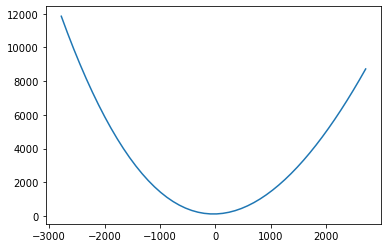

In [20]:
plt.plot(profile["values"], profile["likelihood"]);

## Plot obtained results for sigma

In [21]:
result["mean"]["b"]

mass,sigma_v,std
GeV,cm3 / s,cm3 / s
float64,float64,float64
100.0,1.4092667935066144e-24,4.859936135376643e-25
200.0,9.18990485863355e-25,3.2308693448992218e-25
500.0,7.242050716200608e-25,3.404657311814682e-25
1000.0,6.662491640139337e-25,2.8208265646216396e-25
5000.0,6.571156927384227e-25,3.191011840582899e-25
10000.0,6.923615620404416e-25,3.462779209216684e-25
50000.0,1.3740703382125917e-24,6.311855947904856e-25


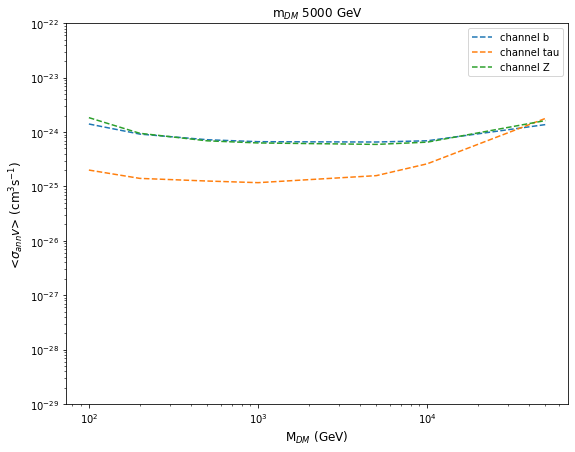

In [22]:
plt.figure(figsize=(9,7))
plt.ylim(1e-29, 1e-22)
plt.ylabel(r"<$\sigma_{ann}v$> (cm$^3$s$^{-1}$)", fontsize=12)
plt.xlabel("M$_{DM}$ (GeV)", fontsize=12)
plt.title('m$_{DM}$ 5000 GeV')

for ch in channels:
    plt.loglog(
        result["mean"][ch]["mass"].data,
        result["mean"][ch]["sigma_v"].data,
        ls="--",
        label='channel {}'.format(ch)
       )
plt.legend();